In [6]:
# IMPORTS FOR DATA PREP
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [7]:
# DATA LOADING & PREPROCESSING
df = pd.read_csv(r"C:\Users\DELL\credit-card-fraud-detection\data\creditcard.csv")

In [8]:
# FEATURE SCALING
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [9]:
# DATA SPLITTING
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# RESAMPLING
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [11]:
print("--- Data Preparation Complete ---")
print("Variables are loaded and ready for model tuning.\n")

--- Data Preparation Complete ---
Variables are loaded and ready for model tuning.



In [12]:
# IMPORTS FOR MODEL TUNING
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

In [13]:
# EVALUATION FUNCTION
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} Evaluation ---")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    print("-" * (len(model_name) + 20) + "\n")

In [14]:
# PARAMETER GRID
params = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 7),
    'n_estimators': randint(100, 300),
    'gamma': uniform(0, 0.5)
}

In [21]:
# INITIALIZE SEARCH
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   n_iter=10, 
                                   scoring='roc_auc', 
                                   cv=5, 
                                   verbose=3, 
                                   random_state=42)

# RUN SEARCH
print("--- Starting Hyperparameter Tuning ---")
random_search.fit(X_train_resampled, y_train_resampled)

In [19]:
# BEST PARAMETERS
print("\n--- Best Hyperparameters Found ---")
print(random_search.best_params_)
print("-" * 36 + "\n")


--- Best Hyperparameters Found ---
{'gamma': 0.03727532183988541, 'learning_rate': 0.20737738732010347, 'max_depth': 6, 'n_estimators': 228}
------------------------------------



C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Optimized XGBoost Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.88      0.82        98

    accuracy                           1.00     56962
   macro avg       0.88      0.94      0.91     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9811

Confusion Matrix:


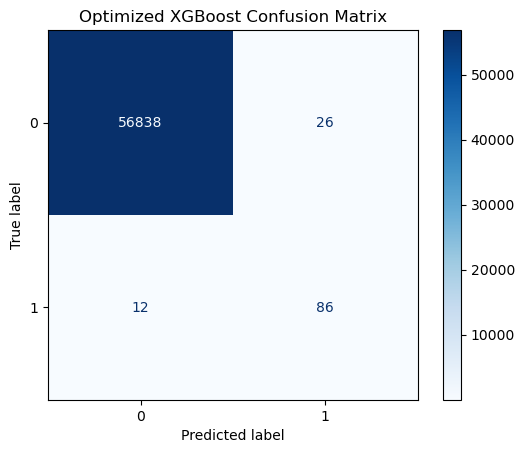

-------------------------------------



In [18]:
# FINAL MODEL EVALUATION
final_xgb = XGBClassifier(random_state=42, 
                          use_label_encoder=False, 
                          eval_metric='logloss', 
                          **random_search.best_params_)

final_xgb.fit(X_train_resampled, y_train_resampled)
y_pred_final = final_xgb.predict(X_test)
y_prob_final = final_xgb.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_final, y_prob_final, 'Optimized XGBoost')

In [22]:
# SAVE THE FINAL MODEL
import joblib

joblib.dump(final_xgb, 'xgboost_fraud_detector.pkl')



['xgboost_fraud_detector.pkl']

In [23]:
# OPTIONAL: Test loading the model back to ensure it works
loaded_model = joblib.load('xgboost_fraud_detector.pkl')
print("Model saved and successfully loaded.")

Model saved and successfully loaded.
